<a href="https://colab.research.google.com/github/esdrasantos/statistical-concepts-and-practice/blob/main/cstfm_mod_8_t_z_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:
from scipy.stats import t
from scipy.stats import norm

# Teste T, P(T>t), t-stat=1.37 e df(degress of freedom)=29
print(t.sf(1.37,29))

# Teste T, P(T<t), t-stat=-4, df=29
print(1-t.sf(-4,29))

# Teste Z, P(Z>z), z-stat=1.03
print(norm.sf(1.03))

0.09060058219219326
0.0002000319728262534
0.15150500278834367


In [159]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [160]:
import numpy as np
import pandas as pd
import os
import re

# Buscando dados de tabelas .csv hospedadas no google drive⚡

In [161]:
dir = '/content/drive/MyDrive/faturas_nu_csv'

arquivos = [arquivo for arquivo in os.listdir(dir)]

padrao = f"_(.*?)-"

arquivosord = sorted(arquivos, key=lambda x: int(re.findall(padrao, x)[0]))
arquivosord = sorted(arquivosord, key=lambda x: int(x.split('-')[1]))
arquivosord

['Nubank_2025-01-11.csv',
 'Nubank_2025-02-11.csv',
 'Nubank_2025-03-11.csv',
 'Nubank_2025-04-11.csv',
 'Nubank_2025-05-11.csv',
 'Nubank_2025-06-11.csv',
 'Nubank_2025-07-11.csv',
 'Nubank_2025-08-11.csv',
 'Nubank_2025-09-11.csv',
 'Nubank_2025-10-11.csv',
 'Nubank_2025-11-11.csv']

In [162]:
dados = pd.DataFrame()

for arquivo in arquivosord:
  tabela = pd.read_csv(f'{dir}/{arquivo}')
  tabela['Arquivo Origem'] = arquivo
  dados = pd.concat([dados,tabela])

dados.reset_index(drop=True,inplace=True)

In [163]:
dados['Fech. Fatura'] = dados['Arquivo Origem']\
.str.rsplit('_', n=1).str[1]\
.str.split('.').str[0]

# Corrigindo as datas das observações ⛴

In [164]:
dia_mes = dados['Data'].str.split(' ')
dados['Dia'] = dia_mes.str[0].str.strip()
dados['Mes'] = dia_mes.str[1].str.strip()
dados['Ano'] = dados['Fech. Fatura'].str\
              .split('-').str[0]\
              .str.strip()
meses = {
    "JAN": 1,
    "FEV": 2,
    "MAR": 3,
    "ABR": 4,
    "MAI": 5,
    "JUN": 6,
    "JUL": 7,
    "AGO": 8,
    "SET": 9,
    "OUT": 10,
    "NOV": 11,
    "DEZ": 12
}

dados['N Mes'] = dados['Mes'].map(meses)

dados['Data_Compra_Aux'] = dados.Ano + "-"\
                           + dados['N Mes'].astype(str) + "-"\
                           + dados.Dia

In [165]:
dados.drop(columns=['Dia','Mes','Ano','N Mes'],inplace=True)

In [166]:
dtdiff = pd.to_datetime(dados['Fech. Fatura'])-pd.to_datetime(dados['Data_Compra_Aux'])
dados['Dias_Compra'] = dtdiff.dt.days

In [167]:
dados.drop(columns=["Data"], inplace=True)

In [168]:
from dateutil.relativedelta import relativedelta

In [169]:
dados['Data'] = pd.to_datetime(dados['Data_Compra_Aux'])
filtro = dados['Dias_Compra'] < 0
dados.loc[filtro, 'Data'] = dados.loc[filtro, 'Data'] - pd.DateOffset(years=1)

In [170]:
dados.drop(columns=['Data_Compra_Aux', 'Dias_Compra'],inplace=True)

# Preparando a amostra para o teste ♟

Queremos saber se a média populacional da Qtd de Compras / Semana é maior que 20.

In [171]:
dados['Ano Compra']= dados.Data.dt.year
dados['Semana do Ano'] = dados['Data'].dt.isocalendar().week

In [172]:
freqsemana = dados[['Ano Compra', 'Semana do Ano']].value_counts()
freqsemana = pd.DataFrame(freqsemana)
freqsemana.sort_values(by=['Ano Compra','Semana do Ano'], inplace=True)
freqsemana.rename(columns={'count':'Qtd Compras'}, inplace=True)
freqsemana.reset_index(inplace=True)
freqsemana.head()

,Ano Compra,Semana do Ano,Qtd Compras
0,2024,1,3
1,2024,48,1
2,2024,49,20
3,2024,50,16
4,2024,51,12


# Alguns histogramas e boxplots ☝

array([<Axes: title={'center': '(2024,)'}>,
       <Axes: title={'center': '(2025,)'}>], dtype=object)

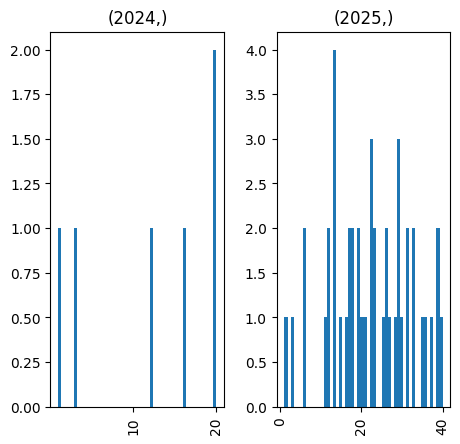

In [173]:
# Gráfico de distribuição de frequencia
#sns.histplot(freqsemana)
freqsemana.hist(
    column='Qtd Compras',
    by=['Ano Compra'],
    figsize=(5, 5),
    grid=False,
    bins=freqsemana['Semana do Ano'].max())

<Axes: xlabel='Semana do Ano'>

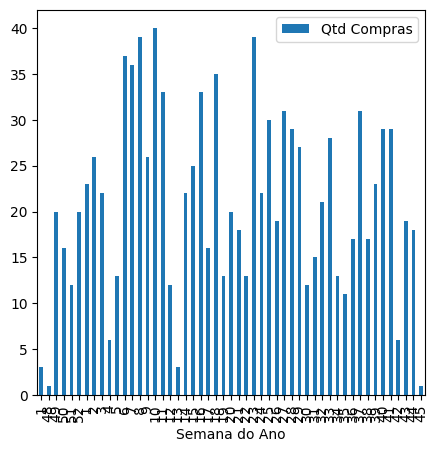

In [174]:
freqsemana.plot.bar(x='Semana do Ano', y='Qtd Compras', figsize=(5, 5))

<Axes: xlabel='Qtd Compras'>

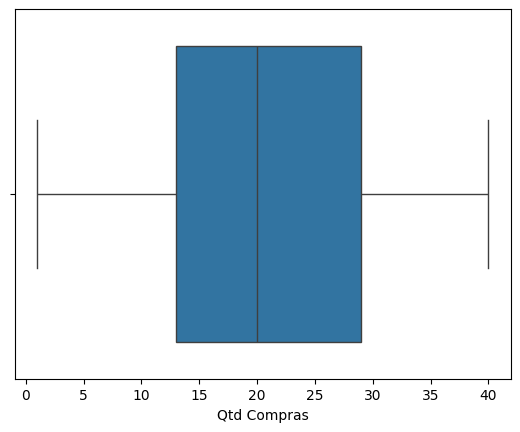

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

sns.boxplot(x=freqsemana['Qtd Compras'])

Text(0.5, 0, 'Qtd Compras')

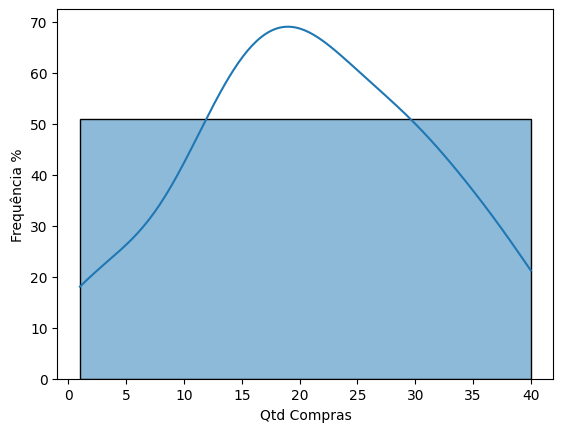

In [176]:
# Cálculo do número de classes, também possível utilizar a Regra de Sturges
bins =  math.ceil((freqsemana['Qtd Compras'].max()\
        -freqsemana['Qtd Compras'].min())\
        /len(freqsemana))
#sns.histplot(freqsemana['Qtd Compras'], bins='auto', kde=True)
sns.histplot(freqsemana['Qtd Compras'], bins=bins, kde=True)
plt.ylabel('Frequência %')
plt.xlabel('Qtd Compras')

In [177]:
# Calcular 30 medias de amostras aleatórias retiradas de dentro do conjunto de dados freqsemana

import numpy as np

num_samples = 80
sample_size = 30

# Teorema Centraal do Limite
dadostcl = []
for _ in range(num_samples):
    sample = np.random.choice(freqsemana['Qtd Compras'], size=sample_size, replace=True)
    sample_mean = np.mean(sample)
    dadostcl.append(sample_mean)

tcl = pd.DataFrame(dadostcl)
tcl.columns=['Média Amostral Qtd Compras / Semana']

<Axes: xlabel='Média Amostral Qtd Compras / Semana'>

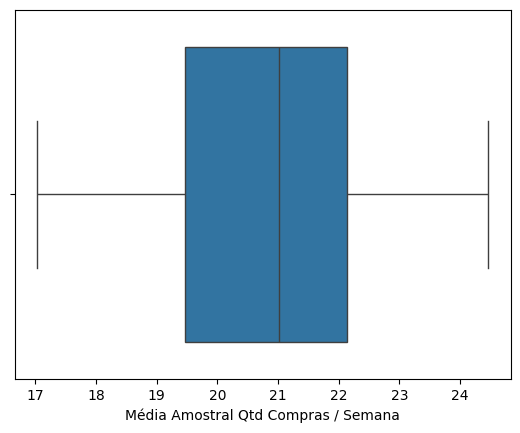

In [178]:
sns.boxplot(x=tcl['Média Amostral Qtd Compras / Semana'], )

Text(0, 0.5, 'Frequência')

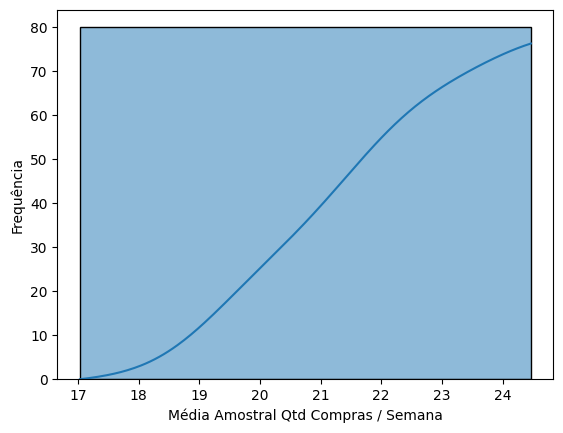

In [179]:
bins =  math.ceil((tcl['Média Amostral Qtd Compras / Semana'].max()\
                  - tcl['Média Amostral Qtd Compras / Semana'].min())\
                  /len(tcl))
sns.histplot(tcl['Média Amostral Qtd Compras / Semana'], kde=True, bins=bins, cumulative=True)
plt.xlabel('Média Amostral Qtd Compras / Semana')
plt.ylabel('Frequência')


Text(0, 0.5, 'Frequência')

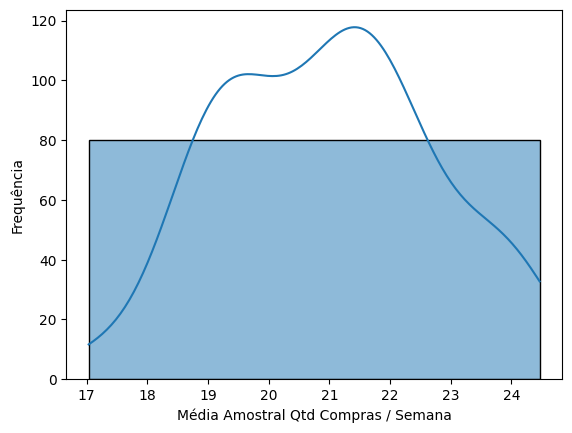

In [180]:
bins =  math.ceil((tcl['Média Amostral Qtd Compras / Semana'].max()\
                  - tcl['Média Amostral Qtd Compras / Semana'].min())\
                  /len(tcl))
sns.histplot(tcl['Média Amostral Qtd Compras / Semana'], kde=True, bins=bins)
plt.xlabel('Média Amostral Qtd Compras / Semana')
plt.ylabel('Frequência')


Text(0, 0.5, 'Frequência')

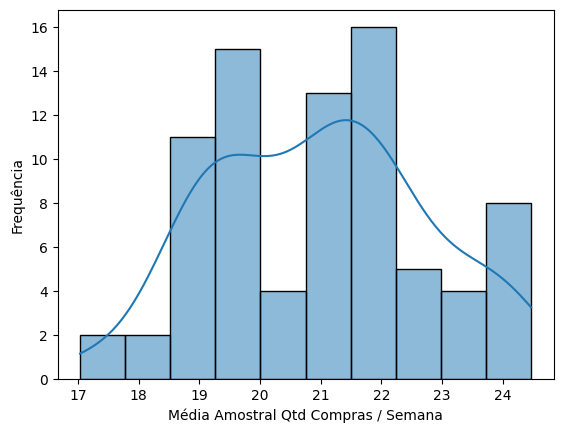

In [181]:
bins=10
sns.histplot(tcl['Média Amostral Qtd Compras / Semana'], kde=True, bins=bins)
plt.xlabel('Média Amostral Qtd Compras / Semana')
plt.ylabel('Frequência')


# Teste T para 1 Média
### Hipotése: A média populacional da Qtd de Compras por Semana é maior que 20.
#### Nível de significância: alfa = 0.05

*   Ho: A média populacional de Qtd de Compras / Semana é menor ou igual a 20.
*   Ha: A média populacional da Qtd de Compras por Semana é maior que 20.
De acordo com postagem no site: https://www.blog.psicometriaonline.com.br/o-que-e-valor-de-p

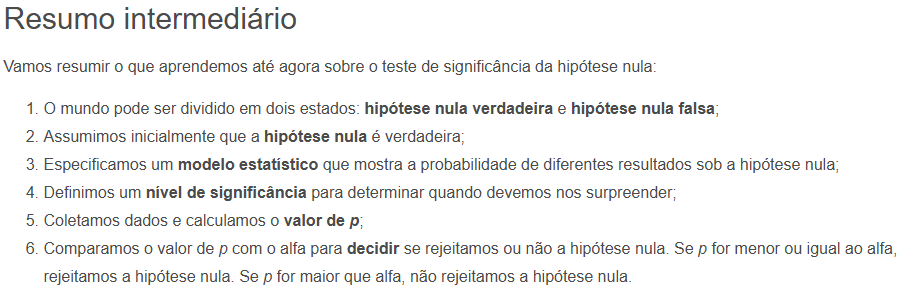

In [182]:
media_amostral = np.mean(tcl['Média Amostral Qtd Compras / Semana'])

print(f'Média amostral = {media_amostral:.4f}')

Média amostral = 20.9842


In [183]:
from scipy.stats import ttest_1samp # Teste T (ttest) para 1 amostra (1samp)

media = 20

test = ttest_1samp(tcl['Média Amostral Qtd Compras / Semana'], media)

(t,pvalor,gl) = test.statistic, test.pvalue, test.df

print(f'Estatística t={t}; p-valor={pvalor}; graus de liberdade={gl}')

Estatística t=5.005730703054266; p-valor=3.306575723999244e-06; graus de liberdade=79


In [184]:
# Decisão

alfa = 0.05

resultado = False

if pvalor < alfa:
    resultado = True
    print('Rejeitamos a hipótese nula')
else:
    print('Não rejeitamos a hipótese nula')

Rejeitamos a hipótese nula


In [185]:
if resultado:
  print('Logo, A média populacional da Qtd de Compras / Semana é maior do que 20.')
else:
  print('Não há evidências para comprovar que A média populacional da Qtd de Compras / Semana é maior do que 20')

Logo, A média populacional da Qtd de Compras / Semana é maior do que 20.


# Normalidade: Teste de Shapiro

*   Ho: Dados seguem a distribuição normal
*   Ha: Dados não seguem a distribuição normal

Considerando um nível de significância expressivo: alfa = 0.10 (10%)

In [186]:
from scipy.stats import shapiro

test = shapiro(tcl['Média Amostral Qtd Compras / Semana'])

(t,pvalor) = test.statistic, test.pvalue

print(f'Estatística t={t}; p-valor={pvalor}')

Estatística t=0.9788539900992607; p-valor=0.2071540466524069


In [187]:
rejeita = False

if pvalor < alfa:
    rejeita = True
    print('Rejeitamos a hipótese nula')
else:
    print('Não rejeitamos a hipótese nula')

Não rejeitamos a hipótese nula


In [188]:
if rejeita:
  print('Logo, os dados não seguem a distribuição normal.')
else:
  print('Os dados seguem a distribuição normal (a princípio) pois não há evidências que comprovem que os dados seguem distribuição assimétrica.')  # é conveniente assumir que os dados são normais

Os dados seguem a distribuição normal (a princípio) pois não há evidências que comprovem que os dados seguem distribuição assimétrica.


# Shapiro para dados assimétricos
A média de compras segue distribuição assimétrica positiva (cauda à direita)

## Preparação dos dados e análise de distr. do Valor das Compras

In [189]:
dados[['Valor','Categoria','Arquivo Origem']].head()

,Valor,Categoria,Arquivo Origem
0,"R$ 12,99",Transporte,Nubank_2025-01-11.csv
1,"R$ 53,28",Shopping e ecommerce,Nubank_2025-01-11.csv
2,"R$ 75,50",Shopping e ecommerce,Nubank_2025-01-11.csv
3,"R$ 53,13",Shopping e ecommerce,Nubank_2025-01-11.csv
4,"R$ 55,20",Shopping e ecommerce,Nubank_2025-01-11.csv


In [190]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np

In [191]:
dados.Valor

# Extrai somente o número decimal
valor = dados.Valor.str\
      .extract(r'(\d+\,\d+)')\
      .replace(',','.', regex=True)\
      .astype(float)
valor.head()

,0
0,12.99
1,53.28
2,75.50
3,53.13
4,55.20


In [192]:
valormin = np.min(valor)
valormax = np.max(valor)

print(f'Valor mínimo = {valormin:.2f}')
print(f'Valor máximo = {valormax:.2f}')

Valor mínimo = 0.00
Valor máximo = 855.61


In [193]:
Q1 = valor.quantile(0.25)[0]
Q2 = valor.quantile(0.50)[0]
Q3 = valor.quantile(0.75)[0]

# Intervalo Interquartil (Interquartile Range)
IQR = Q3 - Q1

(Q1,Q2,Q3,IQR)

(np.float64(13.925), np.float64(29.99), np.float64(60.925), np.float64(47.0))

In [194]:
lim_inferior = (Q1 - 1.5 * IQR)
lim_superior = (Q3 + 1.5 * IQR)

lim_inferior, lim_superior

(np.float64(-56.575), np.float64(131.425))

In [195]:
valor_sem_outlier = valor[(valor >= lim_inferior) & (valor <= lim_superior)].reset_index(drop=True)

valor_sem_outlier.head()

,0
0,12.99
1,53.28
2,75.50
3,53.13
4,55.20


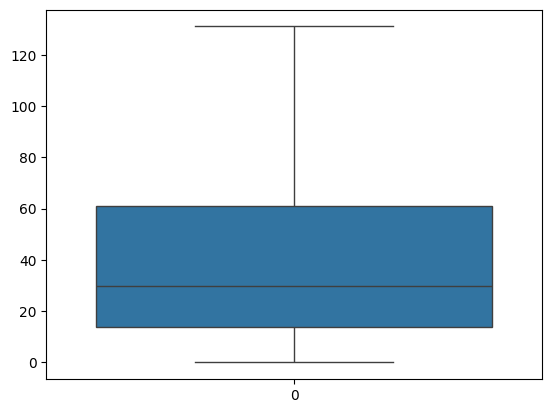

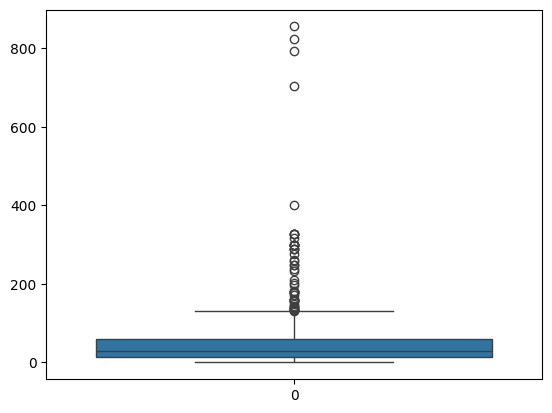

In [196]:
sns.boxplot(data=valor, showfliers=False) # Fliers "mosqueiros" aqui significando os outliers que não temos interesse em mostrar
plt.show()
sns.boxplot(data=valor, showfliers=True)
plt.show()

<Axes: ylabel='Count'>

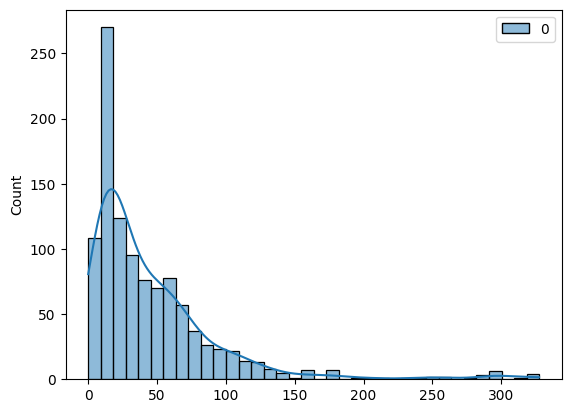

In [197]:
sns.histplot(valor[valor<=400], bins='auto', kde=True)

<Axes: ylabel='Count'>

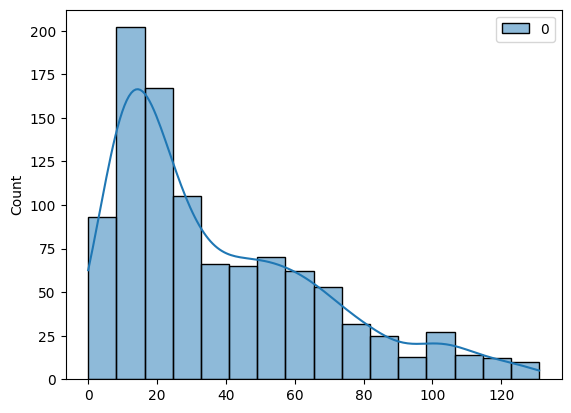

In [198]:
sns.histplot(valor_sem_outlier, bins='auto', kde=True)

## Teste de Shapiro para distribuição assimétrica
### No exemplo: distr. assimétrica positiva (cauda a direita)
---
*   Ho: Distr. dos dados é normal.
*   Ha: Distr. dos dados é assimétrica.

alfa = 0.05

In [199]:
from scipy.stats import shapiro

valor.columns = ['Valor']

test = shapiro(valor.Valor)

(t,pvalor) = test.statistic, test.pvalue

print(f'Estatística t={t}; p-valor={pvalor}')


Estatística t=0.528411106887374; p-valor=1.1675416649672472e-46


In [200]:
# Decisão

rejeita = False
if pvalor < alfa:
    rejeita = True
    print('Rejeitamos a hipótese nula')
else:
    print('Não rejeitamos a hipótese nula')

Rejeitamos a hipótese nula


In [201]:
if rejeita:
  print('Logo, os dados não seguem a distribuição normal.')
else:
  print('Os dados seguem a distribuição normal (a princípio) pois não há evidências que comprovem que os dados seguem distribuição assimétrica.')

Logo, os dados não seguem a distribuição normal.


## Transformação Logarítmica com Numpy

In [202]:
import numpy as np

# Transformação matemática com aplicação linha a linha do logaritmo natural
ln_valores = np.log(valor['Valor'])
ln_valores.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Valor
0,2.564180
1,3.975561
2,4.324133
3,3.972742
4,4.010963


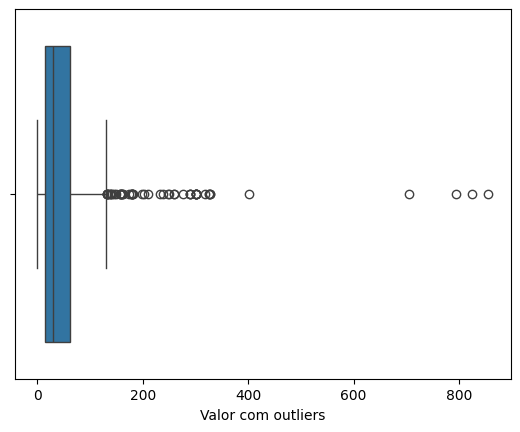

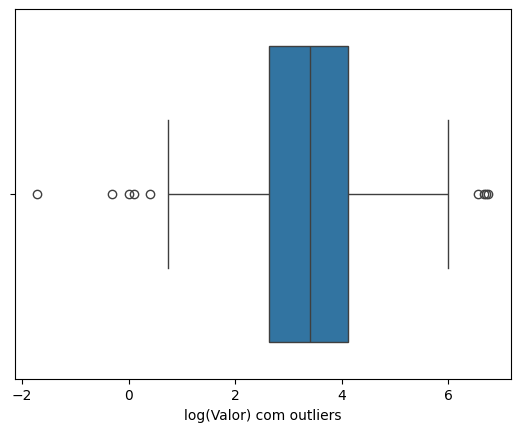

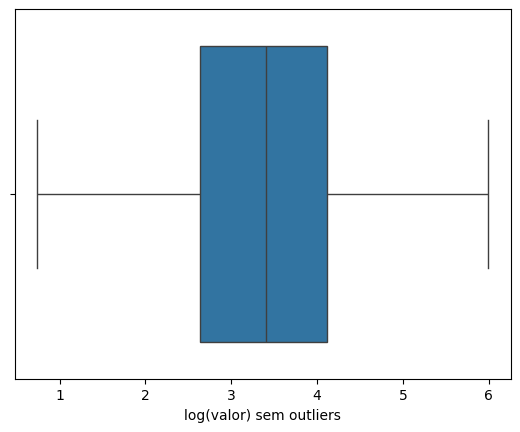

In [203]:
import seaborn as sns

sns.boxplot(valor['Valor'], showfliers=True, orient='h')
plt.xlabel('Valor com outliers')
plt.show()

sns.boxplot(ln_valores, showfliers=True, orient='h')
plt.xlabel('log(Valor) com outliers')
plt.show()

sns.boxplot(ln_valores, showfliers=False, orient='h')
plt.xlabel('log(valor) sem outliers')
plt.show()

Text(0, 0.5, 'Frequência')

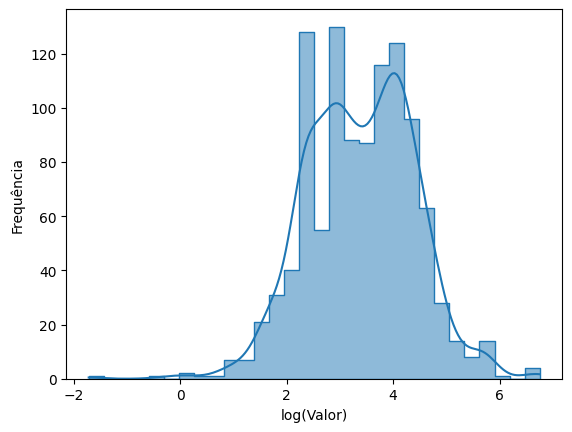

In [204]:
sns.histplot(ln_valores, bins='auto', kde=True, element='step')
plt.xlabel('log(Valor)')
plt.ylabel('Frequência')

In [205]:
# Verifica se há valores infinitos, precisamos removê-los!
eh_infinito = np.isinf(ln_valores)
ln_valores[eh_infinito]

,Valor
205,-inf
206,-inf


In [206]:
ln_valores.dropna(inplace=True)
ln_valores.head()

,Valor
0,2.564180
1,3.975561
2,4.324133
3,3.972742
4,4.010963


In [207]:
ln_valores.drop(ln_valores[eh_infinito].index, inplace=True)
ln_valores[eh_infinito]

,Valor


In [208]:
# Teste de Shapiro em dados transformados com outliers
# Removendo Nan (ex. log(-5)) e infinitos (ex. log(0))
test = shapiro(ln_valores)

(t,pvalor) = test.statistic, test.pvalue

print(f'Estatística t={t}; p-valor={pvalor}')

Estatística t=0.9903327163849749; p-valor=1.76174519576781e-06


In [209]:
quartil = ln_valores.quantile([0.25,0.75])
Q1 = quartil[0.25]
Q3 = quartil[0.75]
IQR = Q3 - Q1

print(f'Q1 = {Q1:.4f}')
print(f'Q3 = {Q3:.4f}')
print(f'IQR = {IQR:.4f}')

ln_valores.sort_values(inplace=True)
ln_valores.reset_index(drop=True, inplace=True)

ln_valores = ln_valores[(ln_valores >= Q1) & (ln_valores <= Q3)]
ln_valores

Q1 = 2.6391
Q3 = 4.1116
IQR = 1.4725


,Valor
266,2.639057
267,2.639057
268,2.639057
269,2.639057
270,2.649715
...,...
796,4.109233
797,4.109233
798,4.109233
799,4.109397


In [210]:
# Teste de Shapiro em dados transformados
test = shapiro(ln_valores)

(t,pvalor) = test.statistic, test.pvalue

print(f'Estatística t={t}; p-valor={pvalor}')

Estatística t=0.9340694695274324; p-valor=1.2731868203856273e-14


Text(0, 0.5, 'Frequência')

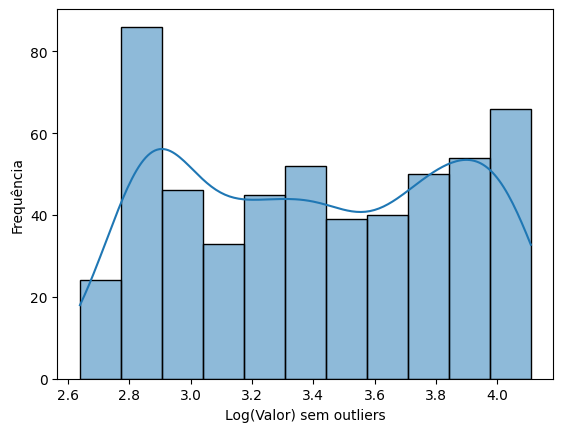

In [211]:
sns.histplot(ln_valores, bins='auto', kde=True)
plt.xlabel('Log(Valor) sem outliers')
plt.ylabel('Frequência')

In [212]:
# Decisão

rejeita = False
if pvalor < alfa:
    rejeita = True
    print('Rejeitamos a hipótese nula')
else:
    print('Não rejeitamos a hipótese nula')

Rejeitamos a hipótese nula


In [213]:
if rejeita:
  print('Logo, os dados não seguem a distribuição normal.')
else:
  print('Os dados seguem a distribuição normal (a princípio) pois não há evidências que comprovem que os dados seguem distribuição assimétrica.')

Logo, os dados não seguem a distribuição normal.


# 2 Médias Independentes
(ttest_ind)


---


Tese: A média do gasto mensal em Shopping e Ecommerce é estatisticamente igual a média do gasto mensal em Ifood.

Ho: μshopping = μifood\
Ha: μshopping <> μifood

In [214]:
dados[['Valor','Categoria','Fech. Fatura']].head()

,Valor,Categoria,Fech. Fatura
0,"R$ 12,99",Transporte,2025-01-11
1,"R$ 53,28",Shopping e ecommerce,2025-01-11
2,"R$ 75,50",Shopping e ecommerce,2025-01-11
3,"R$ 53,13",Shopping e ecommerce,2025-01-11
4,"R$ 55,20",Shopping e ecommerce,2025-01-11


## Preparação de dados


In [215]:
dadoscat = dados[['Valor','Categoria','Fech. Fatura']]
dadoscat.Valor = dadoscat.Valor.str\
                .extract(r'(\d+\,\d+)')\
                .replace(',','.', regex=True)\
                .astype(float)
dadoscat

/tmp/ipython-input-2254711897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dadoscat.Valor = dadoscat.Valor.str\


,Valor,Categoria,Fech. Fatura
0,12.99,Transporte,2025-01-11
1,53.28,Shopping e ecommerce,2025-01-11
2,75.50,Shopping e ecommerce,2025-01-11
3,53.13,Shopping e ecommerce,2025-01-11
4,55.20,Shopping e ecommerce,2025-01-11
...,...,...,...
1065,31.00,Transporte,2025-11-11
1066,17.90,Lavanderia,2025-11-11
1067,5.87,Transporte,2025-11-11
1068,126.86,Mercados,2025-11-11


In [216]:
dadoscat = dadoscat[dadoscat.Categoria.isin(['Shopping e ecommerce','Ifood'])]
dadoscat.head()

,Valor,Categoria,Fech. Fatura
1,53.28,Shopping e ecommerce,2025-01-11
2,75.50,Shopping e ecommerce,2025-01-11
3,53.13,Shopping e ecommerce,2025-01-11
4,55.20,Shopping e ecommerce,2025-01-11
5,30.08,Shopping e ecommerce,2025-01-11


In [217]:
dadosagrupados = dadoscat.groupby(['Categoria']).agg({'Valor':'mean'} )
dadosagrupados.Valor = dadosagrupados.Valor.round(2)
dadosagrupados

,Valor
Categoria,
Ifood,62.04
Shopping e ecommerce,56.59


## Agrupamento de média por Categoria
['Ifood', 'Shopping e ecommerce']

In [218]:
from scipy.stats import ttest_ind

# Teste T (ttest) para 2 amostras

# Assumindo variâncias iguais
test = ttest_ind(dadoscat[dadoscat.Categoria == 'Ifood'].Valor,
                 dadoscat[dadoscat.Categoria == 'Shopping e ecommerce'].Valor,
                 equal_var=True)
test

TtestResult(statistic=np.float64(1.1929974860143784), pvalue=np.float64(0.23369015265266654), df=np.float64(345.0))

In [219]:
print(f'Estatística t={test.statistic:.4f}; p-valor={test.pvalue:.4f}; df={test.df:.4f}; Variâncias Iguais.')

Estatística t=1.1930; p-valor=0.2337; df=345.0000; Variâncias Iguais.


In [220]:
test = ttest_ind(dadoscat[dadoscat.Categoria == 'Ifood'].Valor,
                 dadoscat[dadoscat.Categoria == 'Shopping e ecommerce'].Valor,
                 equal_var=False)
test

TtestResult(statistic=np.float64(1.193336547507192), pvalue=np.float64(0.23356283939950187), df=np.float64(342.79308400271714))

In [221]:
print(f'Estatística t={test.statistic:.4f}; p-valor={test.pvalue:.4f}; df={test.df:.4f}; Variâncias Diferentes.')

Estatística t=1.1933; p-valor=0.2336; df=342.7931; Variâncias Diferentes.


In [222]:
# Mas as variâncias podem ser diferentes, verifique-mos
dfIfood = dadoscat[dadoscat.Categoria == 'Ifood']
dfShopping = dadoscat[dadoscat.Categoria == 'Shopping e ecommerce']

In [223]:
ifood_dp = dfIfood.Valor.std()
shopping_dp = dfShopping.Valor.std()

print(f'Desvio padrão Ifood = {ifood_dp:.4f}')
print(f'Desvio padrão Shopping = {shopping_dp:.4f}')

Desvio padrão Ifood = 42.3011
Desvio padrão Shopping = 42.5793


### Teste de Levene para verificar se variâncias iguais

Ho: Variancias iguais\
Ha: Variancias diferentes\
alfa = 0.10

In [224]:
from scipy.stats import levene
stat, p_valor = levene(dfIfood.Valor, dfShopping.Valor)

print(f'Estatística t={stat:.4f}; p-valor={p_valor:.4f}')

Estatística t=0.2654; p-valor=0.6068


In [225]:
# Decisão quanto as variâncias das médias de 'Ifood' e 'Shopping e ecommerce'

if p_valor < alfa:
    print('Rejeitamos a hipótese nula.')
    print('Portanto, as variâncias são diferentes.')
else:
    print('Não rejeitamos a hipótese nula')
    print('Portanto, não há evidências que comprovem que as variâncias são diferentes.')

Não rejeitamos a hipótese nula
Portanto, não há evidências que comprovem que as variâncias são diferentes.


## Assumindo igual variância da média mensal para diferentes categorias

In [226]:
# Assumindo variâncias iguais
test = ttest_ind(dadoscat[dadoscat.Categoria == 'Ifood'].Valor,
                 dadoscat[dadoscat.Categoria == 'Shopping e ecommerce'].Valor,
                 equal_var=True)
stat, p_valor = test.statistic, test.pvalue

print(f'Estatística t={stat:.4f}; p-valor={p_valor:.4f}; Variâncias Iguais.')

Estatística t=1.1930; p-valor=0.2337; Variâncias Iguais.


In [227]:
alfa = 0.05

if p_valor < alfa:
    print('Rejeitamos a hipótese nula')
    print('Portanto, há evidências de que as médias sejam distintas estatisticamente.')
else:
    print('Não rejeitamos a hipótese nula')
    print('Portanto, não há evidências de que as médias sejam distintas estatisticamente.')

Não rejeitamos a hipótese nula
Portanto, não há evidências de que as médias sejam distintas estatisticamente.


# 2 Média Dependentes

Hipótese Alternativa: A média de gasto acumulado na categoria Shopping e Ecommerce depois da intervenção em 3 momentos é menor do que antes das intervenções.

Ho: μ_depois >= antes \
Ha: μ_depois < μ_antes \

Ou

Ho: μ_depois - μ_antes >= 0 \
Ha: μ_depois - μ_antes < 0 \

Tipo de teste: lateral à esquerda (a média amostral é menor que a estatística do status quo?) \

Nível de significância: 10%



In [228]:
import numpy as np
import pandas as pd

'''
suposicao = [[1200,900],[1280,1020], [1100, 850]]
dfsuposicao = pd.DataFrame(suposicao)
dfsuposicao.columns = ['Antes', 'Depois']
'''

np.random.seed(42) # Reprodutível

# 30 valores “Antes” gerados com distribuição normal (média 1250, desvio padrão 120)
antes = np.random.normal(loc=1250, scale=120, size=30)

# Reduções médias de 180 com desvio 40
reducoes = np.random.normal(loc=180, scale=40, size=30)

depois = antes - reducoes

depois = np.clip(depois, a_min=0, a_max=1800).round(2)
antes = antes.round(2)

dfsuposicao = pd.DataFrame({'Antes':antes, 'Depois':depois})

print('Teste de hipótese com suposição antes e depois de intervenção para acumulado em Shopping e ecommerce')
dfsuposicao[:5].style.set_caption('Acum. em Shopping e ecommerce')

Teste de hipótese com suposição antes e depois de intervenção para acumulado em Shopping e ecommerce


,Antes,Depois
0,1309.610000,1153.670000
1,1233.410000,979.320000
2,1327.720000,1148.260000
3,1432.760000,1295.070000
4,1221.900000,1009.000000


In [229]:
from scipy.stats import ttest_rel  # T teste relacionado

antes = dfsuposicao['Antes']
depois = dfsuposicao['Depois']

print(f'Média antes = {np.mean(antes):.4f}')
print(f'Média depois = {np.mean(depois):.4f}')

t_stat, p_valor = ttest_rel(depois, antes, alternative='less')


print(f'Estatística t={t_stat:.4f}; p-valor={p_valor:.4f}')


Média antes = 1227.4223
Média depois = 1052.2680
Estatística t=-25.7575; p-valor=0.0000


In [230]:
alfa = 0.10

if p_valor < alfa:
    print('Rejeitamos a hipótese nula')
    print(f'Portanto a média depois das intervenções é menor do que antes, num nível de significância de {0.1*100}%')
else:
    print('Não rejeitamos a hipótese nula.')
    print(f'Portanto, não há evidencias de que a média seja menor depois das intervenções, num nível de significância de {0.1*100}%') # ~Ha

Rejeitamos a hipótese nula
Portanto a média depois das intervenções é menor do que antes, num nível de significância de 10.0%


## Devaneios com respeito ao cálculo de t_stat em uma amostra

In [231]:
import numpy as np

print('Calculando t da estatística do status quo: μ_antes\n')

x = np.mean(dfsuposicao['Antes'][0])
media_pop = np.mean(dfsuposicao['Antes'])
dp = np.std(dfsuposicao['Antes'])
n = 1

print(f'Média amostral = {x:.4f}')
print(f'Tamanho da amostra = {n}')
print(f'Média populacional = {media_pop:.4f}')
print(f'Desvio padrão populacional = {dp:.4f}')

t_stat = (x - media_pop) / (dp / np.sqrt(n))

print(f't_stat= {t_stat:.4f}')

Calculando t da estatística do status quo: μ_antes

Média amostral = 1309.6100
Tamanho da amostra = 1
Média populacional = 1227.4223
Desvio padrão populacional = 106.1857
t_stat= 0.7740


In [232]:
x = np.mean(depois)
media_pop = np.mean(antes)
s = np.std(depois)                  # Desvio amostral
n = len(dfsuposicao['Depois'])
gl = n-1

t_valor_calculado = (x - media_pop) / (s / np.sqrt(n))

print(f'Média amostral = {x:.4f}')
print(f'Tamanho da amostra = {n}')
print(f'Média populacional = {media_pop:.4f}')
print(f'Desvio padrão amostral = {s:.4f}')
print(f'Graus de liberdade {gl}')

print(f't_valor = {t_valor_calculado:.4f}')


Média amostral = 1052.2680
Tamanho da amostra = 30
Média populacional = 1227.4223
Desvio padrão amostral = 108.8464
Graus de liberdade 29
t_valor = -8.8139


## Teste de Shapiro


In [233]:
from scipy.stats import shapiro

antes_shapiro = shapiro(dfsuposicao['Antes'])
depois_shapiro = shapiro(dfsuposicao['Depois'])

t_antes, p_antes = antes_shapiro.statistic, antes_shapiro.pvalue
t_depois, p_depois = depois_shapiro.statistic, depois_shapiro.pvalue

print(f'Estatística t_antes={t_antes:.4f}; p-valor={p_antes:.4f}')
print(f'Estatística t_depois={t_depois:.4f}; p-valor={p_depois:.4f}')

Estatística t_antes=0.9751; p-valor=0.6868
Estatística t_depois=0.9644; p-valor=0.3982


In [234]:
# Nível de significância para rejeição ou não rejeição
alfa = 0.05

if p_antes < alfa:
    print('Rejeitamos a hipótese nula')
    print('Portanto, os dados não seguem a distribuição normal.')
else:
    print('Não rejeitamos a hipótese nula')
    print('Portanto, não há evidências que comprovem que os dados seguem distribuição assimétrica.')

Não rejeitamos a hipótese nula
Portanto, não há evidências que comprovem que os dados seguem distribuição assimétrica.


# 2 Proporções Teste A/B


In [235]:
from statsmodels.stats.proportion import proportions_ztest

In [237]:
''' Binomial

✔️ Sucesso (p)
A média mensal da categoria Shopping e Ecommerce é pelo menos 20% menor do que o maior valor registrado antes da intervenção.

❌ Insucesso (q)
A média mensal da categoria Shopping e Ecommerce não atinge uma redução mínima de 20% em relação ao maior valor registrado antes da intervenção.

# valor máx -> v_max
# x <= 0.8*v_max

'''

dfsuposicao.head()


,Antes,Depois
0,1309.61,1153.67
1,1233.41,979.32
2,1327.72,1148.26
3,1432.76,1295.07
4,1221.90,1009.00


Suponhamos que queremos provar que a média mensal na categoria Shopping e Ecommerce teve redução de no mínimo 20%

> Ho: μ >= 0.8*v_max \
Ha: μ < 0.8*v_max

Transformando em proporções

p_a = x_a / n_a
p_b = x_b / n_b

p = (x_a + x_b) / (n_a + n_b)

> Ho: A proporção em Depois é menor ou igual a proporção em Antes. \
Ha: A proporção em Depois é maior que a proporção em Antes.

Caso de sucesso: A proporção em Depois é maior para valores com redução mínimo de 20%.
O que significa que a intervenção teve efeito

> Ho: p_b <= p_a \
Ha: p_b > p_a

Nível de siginificância (para rejeição de Ho):
α = 0.1

In [238]:
v_max_a = dfsuposicao['Antes'].max()
v_max_b = dfsuposicao['Depois'].max()

print(f'Valor máximo antes da intervenção = {v_max_a}')
print(f'Valor máximo depois da intervenção = {v_max_b}')

Valor máximo antes da intervenção = 1439.51
Valor máximo depois da intervenção = 1295.07


In [240]:
n_a = len(dfsuposicao['Antes'])
n_b = len(dfsuposicao['Depois'])

In [243]:
x_a = (dfsuposicao['Antes'] <= 0.8*v_max_a).sum()
x_b = (dfsuposicao['Depois'] <= 0.8*v_max_b).sum()

print(f'Casos de sucesso em Antes = {x_a}')
print(f'Casos de sucesso em Depois = {x_b}')

Casos de sucesso em Antes = 7
Casos de sucesso em Depois = 15


In [244]:
p_a = x_a / n_a
p_b = x_b / n_b

print(f'Proporção em Antes = {p_a:.4f}')
print(f'Proporção em Depois = {p_b:.4f}')

Proporção em Antes = 0.2333
Proporção em Depois = 0.5000


In [245]:
from statsmodels.stats.proportion import proportions_ztest

stat, p_valor = proportions_ztest([p_a, n_a], [p_b, n_b])

print(f'Estatística t={stat:.4f}; p-valor={p_valor:.4f}')

Estatística t=-4.0176; p-valor=0.0001


In [249]:
if p_valor < alfa:
    print('Rejeitamos a hipótese nula.')
    print('Portanto, a proporção em Depois é maior que a proporção em Antes.')
    print('Podemos dizer que houve redução de no mínimo 20% nos valores mensais.')
else:
    print('Não rejeitamos a hipótese nula.')
    print('Portanto, não há evidências para comprovar que a proporção em Depois é maior que a proporção em Antes.')
#

Rejeitamos a hipótese nula.
Portanto, a proporção em Depois é maior que a proporção em Antes.
Podemos dizer que houve redução de no mínimo 20% nos valores mensais.
